# 3)
### (a)
- Investigue la longitud eclíptica del nodo ascendente (respecto a la eclíptica) de la órbita de la Luna y su inclinación.


In [1]:
import numpy as np
import datetime
#Funciones y constantes
cos, sin, tan = np.cos, np.sin, np.tan
arcsin, arccos, arctan = np.arcsin, np.arccos, np.arctan
pi = np.pi
torad = pi/180
ToSideral = 1.00273790935079
#Función para hallar el día juliano de una fecha
def JD(date):
    '''Calcula el día juliano para la fecha determinada
    date: Tupla, lista o arreglo de 6 componentes: año(Y),Mes(M),Día(D),hora(h),minutos(m) y segundos(s)
    Ejemplo:
    date = (Year,Month,Day,hour,minute,second)= (2000,06,21,12,30,15.3) corresponde a las 12:30:15.3 horas del 21/Junio/2000; 
    Retorna un float JDay con una precisión de 9 dígitos
    '''
    Yp,Mp,Dp,hp,mp,sp = date
    D_ = Dp+(hp+mp/60+sp/3600)/24
    if (Mp==1 or Mp==2):
        Yp,Mp = Yp-1,Mp+12
    A = int(Yp/100)
    B = 2-A+int(A/4)
    JDay = int(365.25*(Yp+4716))+int(30.6001*(Mp+1))+D_+B-1524.5
    return round(JDay,9)

#Fórmula para calcular la longitud del nodo ascendente lunar en una fecha determinada
#Tomado del algoritmo presentado por Meeus en 'Astronomical Algorithms';Willmann-Bell
def l_nodo(date):
    #import datetime
    #x = datetime.datetime.now()
    #date = Y,M,D,h,m,s = [x.year,x.month,x.day,x.hour,x.minute,x.second]
    jd = JD(date)
    T = (jd - 2451545.0)/36525
    r = 125.0445479 - 1934.1362891*T + 0.0020754*(T**2) + (T**3)/467441 - (T**4)/60616000
    lon_nodo = [r if r>0 else 360+r][0]
    return lon_nodo

#Algoritmo ELP desarrollado por Meeus en 'Astronomical Algorithms' de Willmann y Bell
#Archivos con las tablas de los coeficientes y los argumentos para calcular la posición de la Luna en determinado momento
#Matrices usadas para calcular las combinaciones lineales, tal como se indica en el capítulo 47 del libro de Meeus
Matrix1 = np.loadtxt('Longitude_distance_periodic.txt', skiprows=1, usecols=(0,1,2,3)) #Table 47; Chapther 47.A
Matrix2 = np.loadtxt('Latitude_periodic.txt', skiprows=1, usecols=(0,1,2,3)) #Table 47.B; Chapter 47
SUMS = np.loadtxt('Longitude_distance_periodic.txt', skiprows=1, usecols=(4,5))
#Coeficientes de seno y coseno para calcular sum_l, sum_r y sum_b (Ver página 338)
coeff_b = np.loadtxt('Latitude_periodic.txt', skiprows=1, usecols=(4))
coeff_l,coeff_r, = SUMS[:,0],SUMS[:,1]
#Moon mean longitude
L_f = lambda T: 218.3164477+481267.88123421*T-0.0015786*(T**2)+(T**3)/538841-(T**4)/65194000
#Mean elongation of the Moon
Df = lambda T: 297.8501921+445267.1114034*T-0.0018819*(T**2)+(T**3)/545868-(T**4)/113065000
#Sun's mean anomaly
Mf = lambda T: 357.5291092+35999.0502909*T-0.0001536*(T**2)+(T**3)/24490000
#Moon's Mean anomaly
M_f = lambda T: 134.9633964+477198.8675055*T+0.0087414*(T**2)+(T**3)/69699-(T**4)/14712000
#Moon's argument of latitude
Ff = lambda T: 93.2720950+483202.0175233*T-0.0036539*(T**2)-(T**3)/3526000+(T**4)/863310000
#Aditional Arguments
A1f = lambda T: 119.75+131.849*T
A2f = lambda T: 53.09+479264.290*T
A3f = lambda T: 313.45+481266.484*T
#Earth's Orbit Eccentricity
Ef = lambda T: 1-0.002516*T-0.0000074*(T**2)

#Cálculo de T (Ver 'Astronomical Algorithms' Chapter 12, pag 87, eq. 12.1)
Tf = lambda date: round((JD(date)-2451545.0)/36525,13)
#Coordenadas eclípticas de la Luna (lambda y beta) y distancia al centro de la órbita (deltaf) en Km para una fecha dada:
lamf = lambda L_,sum_l: L_ + sum_l/1000000
betf = lambda sum_b: sum_b/1000000
deltaf = lambda sum_r: 385000.56+sum_r/1000

In [2]:
#Ejemplo: Calcular la posición de la Luna el 12 de abril de 1992
date = [1992,4,12,0,0,0]
#Se calcula T
T = Tf(date)
#Se calculan los elementos orbitales para la época usando las eq. 47.1 a la 47.6 (Ver libro)
L_,D,M,M_,F,E = round(L_f(T)-(L_f(T)//360)*360,6), round(Df(T)-(Df(T)//360)*360,6), round(Mf(T)-(Mf(T)//360)*360,6), round(M_f(T)-(M_f(T)//360)*360,6), round(Ff(T)-(Ff(T)//360)*360,6),round(Ef(T)-(Ef(T)//360)*360,6)
A1,A2,A3 = round(A1f(T)-(A1f(T)//360)*360,6),round(A2f(T)-(A2f(T)//360)*360,6),round(A3f(T)-(A3f(T)//360)*360,6)
#Se calculan los coeficientes de seno y coseno
arr = [D,M,M_,F]
M_n = arr*Matrix1
M_n2 = arr*Matrix2
#Se inician los contadores para calcular sum_l, sum_b, sum_r.
sum_l = sum_r = sum_b = 0.
#Calcular las sumas
for i in range(len(Matrix1)):
    #Si M o -M: coeff*E*sin/cos; si 2M o -2M: coeff*E**2*sin/cos
    power = abs(M_n[i][1])
    sum_l += [round(coeff_l[i]*(E**power)*sin(M_n[i].sum()*torad),2) if (power==1 or power==2) else round(coeff_l[i]*sin(M_n[i].sum()*torad),2)][0]
    sum_r += [round(coeff_r[i]*(E**power)*cos(M_n[i].sum()*torad),2) if (power==1 or power==2) else round(coeff_r[i]*cos(M_n[i].sum()*torad),2)][0]
    sum_b += [round(coeff_b[i]*(E**power)*sin(M_n2[i].sum()*torad),2) if (power==1 or power==2) else round(coeff_b[i]*sin(M_n2[i].sum()*torad),2)][0]

sum_l += 3958*sin(round(A1*torad,2))+1962*sin(round(L_*torad-F*torad,2))+318*sin(round(A2*torad,2))
sum_b += -2235*sin(round(L_*torad,2))+382*sin(round(A3*torad,2))+175*sin(round(A1*torad-F*torad,2))+175*sin(round(A1*torad+F*torad,2))+127*sin(round(L_*torad-M_*torad,2))-115*sin(round(L_*torad+M_*torad,2))
lam,bet,delta = lamf(L_,sum_l), betf(sum_b), deltaf(sum_r)

### (b)
- Construya la representación geométrica necesaria para identificar las relaciones entre los elementos de ambos sistemas de coordenadas.

# Profe esta se la quedo debiendo, en este momento no tengo la facilidad de tomar fotos ni escanear. Mi hermana, que es la que me colabora con las fotos, no está. Apenas llegue le pido el favor y se las envío.

### (c)
- Encuentre las ecuaciones necesarias para realizar la transformación entre ambos sistemas.

$$\tan{\lambda_{L}} = \frac{\sin{\beta}\sin{i} - \cos{\beta}\cos{i}\sin{|\lambda_{\Omega}-\lambda|}}{\cos{\beta}\cos{|\lambda_{\Sigma}-\lambda|}} $$

$$ \sin{\beta_{L}} =  \sin{\beta}\cos{i} + \cos{\beta}\sin{i}\sin{|\lambda_{\Omega}-\lambda|}$$

Donde $\lambda_{L}$ es la longitud y $\beta_{L}$ es la 'latitud' en el sistema de coordenadas lunares. Por su parte, $\beta$ es la latitud eclíptica, $\lambda_{\Omega}$ es la longitud eclíptica del node ascendente y $\lambda$ la longitud eclíptica del satélite.

De manera semejante, para transformar de 'coordenadas lunares' a coordenadas eclípticas:

$$\tan{|\lambda_{\Omega}-\lambda|} = \frac{\sin{\beta_{L}}\sin{i} - \cos{\beta_{L}}\cos{i}\sin{\lambda_{L}|}}{\cos{\beta_{L}}\cos{\lambda_{L}}} $$

$$ \sin{\beta} =  \sin{\beta_{L}}\cos{i} + \cos{\beta_{L}}\sin{i}\sin{\lambda_{L}}$$


### (d)
- Implemente sus resultados en un programa de computadora, el cual reciba coordenadas eclípticas y devuelva coordenadas en su sistema de la Luna, y viceversa.


In [3]:
date = [1992,4,12,0,0,0]

def Eclipticas_a_Lunares(lon_ecl,lat_ecl,lam_node):
    lon_node = lam_node
    C = lon_node-lon_ecl
    i = 5.15 #°
    lun_dec = arcsin(sin(lat_ecl*torad)*cos(i*torad) + cos(lat_ecl*torad)*sin(i*torad)*sin(C*torad))/torad
    p = sin(ecl_lat*torad)*sin(i*torad)-cos(ecl_lat*torad)*cos(i*torad)*sin(C*torad)
    q = cos(ecl_lat*torad)*cos(C*torad)
    lun_lon = [180+arctan(p/q)/torad if ((p*q<0 and q<0) or (p+q<0)) else [360+arctan(p/q)/torad if (p*q<0 and q>0) else arctan(p/q)/torad ][0] ][0]
    return [lun_dec,lun_lon/torad]
def Lunares_a_Ecliptica(lun_dec,lun_lon):
    i = 5.15 #°
    lat_ecl = arcsin(sin(lun_dec*torad)*cos(i*torad) + cos(lun_dec*torad)*sin(i*torad)*sin(lun_lon*torad))/torad
    p = sin(lun_dec*torad)*sin(i*torad)-cos(lun_dec*torad)*cos(i*torad)*sin(lun_lon*torad)
    q = cos(lun_dec*torad)*cos(lun_lon*torad)
    lon_ecl = [180+arctan(p/q)/torad if ((p*q<0 and q<0) or (p+q<0)) else [360+arctan(p/q)/torad if (p*q<0 and q>0) else arctan(p/q)/torad ][0] ][0]
    return [lat_ecl,lon_ecl/torad]

### (e)
- De forma análoga al problema número 2, construya una función para encontrar las “coordenadas lunares” de la Luna cada día del año, tomando como referencia el día en que la misma pasa por el nodo ascendente de su órbita en el presente año. Con ayuda de un programa de computación, cree una tabla con estas coordenadas para cada día del año.


In [4]:
#Función para calcular las 'coordenadas lunares' de la Luna cada día del año, tomando como origen el momento en que la
#Luna pasa por el nodo ascendente.
def lunar_long(deltaT, w_luna=13.176359, w_node=0.0529907 ): #w_luna y w_node están en unidades [°/dia]
    new_long = (w_node+w_luna)*deltaT - ((w_node+w_luna)*deltaT//360)*360
    return new_long

### (f)
- Finalmente, utilice su programa de transformación para encontrar las coordenadas eclípticas de la Luna a partir de las coordenadas lunares encontradas en el inciso anterior y compare con datos tomados de otra fuente.

In [12]:
#Días del año, empezando con el 1 el 1 de enero y 365/366 el 31 de diciembre
year = np.linspace(0,366,1000)
#Calcula la longitud en el sistema de coordenadas lunares (latitud=0(aprox) pues La Luna se mueve por ese plano)
longitudes = [lunar_long(i+1) for i in year]
#Convierte esas coordenadas 'lunares' a coordenadas eclípticas usando la función Lunares_a_Ecliptica
coord = np.array([Lunares_a_Ecliptica(0,longitudes[i]) for i in range(len(longitudes))])
#ecl_lat es la latitud eclíptica y ecl_lon es la longitud eclíptica de la Luna a partir de las 'coordenadas lunares'
ecl_lat1,ecl_lon1 = coord[:,0]-(coord[:,0]//90)*90,coord[:,1]-(coord[:,1]//360)*360

(0.0, 360.0)

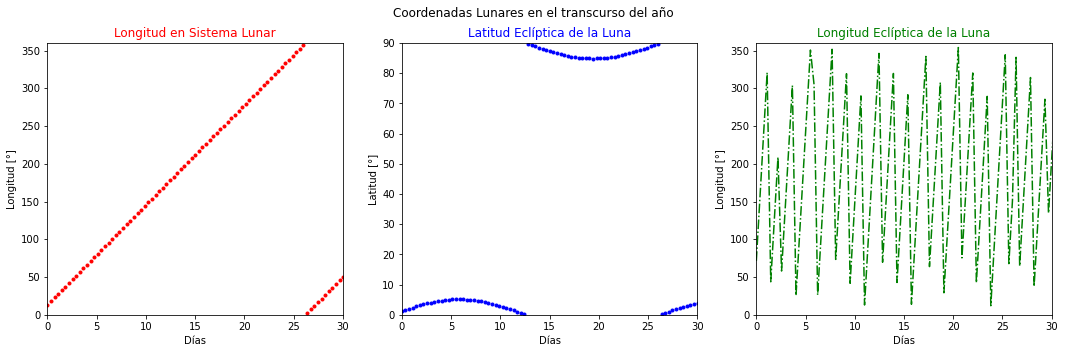

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(18,5))
plt.suptitle('Coordenadas Lunares en el transcurso del año')

ax[0].plot(year,longitudes,'r.')
ax[0].set_title('Longitud en Sistema Lunar', color='r')
ax[0].set_xlabel('Días')
ax[0].set_ylabel('Longitud [°]')
ax[0].set_xlim([0,30])
ax[0].set_ylim([0,360])

ax[1].plot(year,ecl_lat1, 'b.' )
ax[1].set_title('Latitud Eclíptica de la Luna', color='b')
ax[1].set_xlabel('Días')
ax[1].set_ylabel('Latitud [°]')
ax[1].set_xlim([0,30])
ax[1].set_ylim([0,90])

ax[2].plot(year,ecl_lon1, 'g-.' )
ax[2].set_title('Longitud Eclíptica de la Luna', color='g')
ax[2].set_xlabel('Días')
ax[2].set_ylabel('Longitud [°]')
ax[2].set_xlim([0,30])
ax[2].set_ylim([0,360])